In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import warnings
import missingno as msn
import random

import matplotlib.pyplot as plt
import seaborn as sns

# Plot options
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('seaborn')
%matplotlib inline

# Clustering
from sklearn.preprocessing import StandardScaler
import yellowbrick
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as shc

# Other options
warnings.filterwarnings('ignore')

/home/gcuder/anaconda3/envs/smartmeter/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/gcuder/anaconda3/envs/smartmeter/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/gcuder/anaconda3/envs/smartmeter/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [260]:
def cluster_summary(X, y):
    X['label'] = y
    summary = X.groupby('label').mean().apply(lambda x: round(x, 2))
    summary['cluster_size'] = X.groupby('label').size()
    return summary.T

In [2]:
df = pd.read_csv('../data/processed/london_2013.csv', parse_dates=['DateTime'])
df.drop(['stdorToU', 'date', 'time'], 1, inplace=True)
df.head()

,DateTime,LCLid,consumption
0,2013-01-01 00:00:00,MAC000003,1.966
1,2013-01-01 00:30:00,MAC000003,1.922
2,2013-01-01 01:00:00,MAC000003,1.808
3,2013-01-01 01:30:00,MAC000003,0.795
4,2013-01-01 02:00:00,MAC000003,1.235


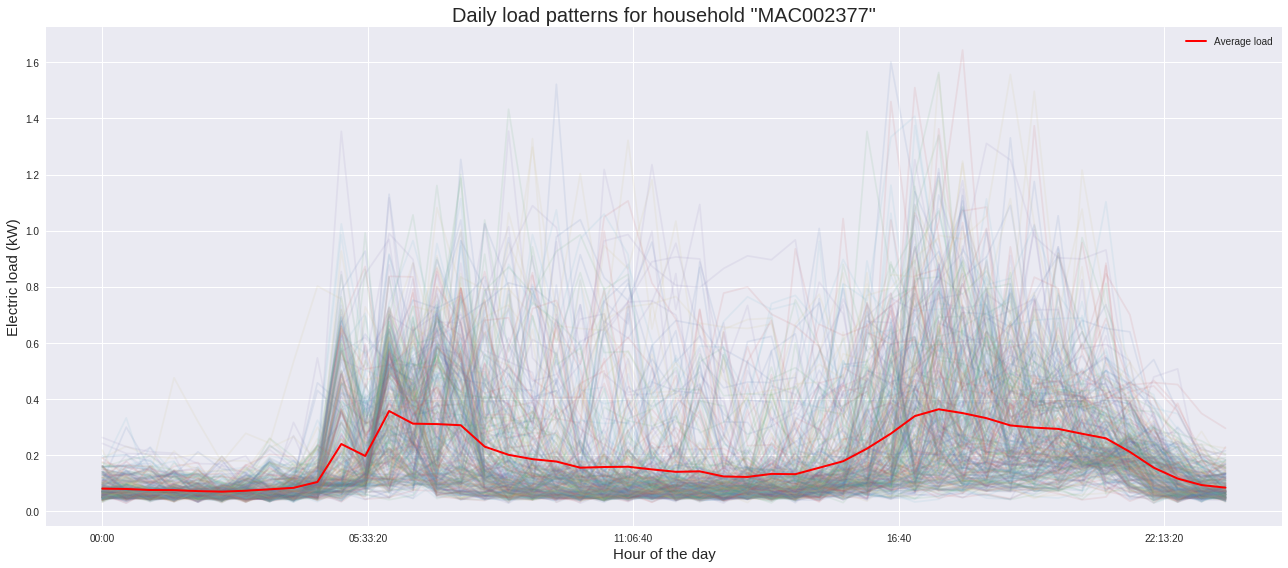

In [197]:
# Draw a random sample household
household_sample = random.choice(df.LCLid.unique())
df_sample = df[df.LCLid == household_sample]
df_sample.set_index('DateTime', inplace=True)
df_sample.drop(['LCLid'], 1, inplace=True)


# Extracting necessary variables
df_sample_plot = df_sample.reset_index()
df_sample_plot['date'] = df_sample_plot['DateTime'].apply(lambda x: x.date())
df_sample_plot['time'] = df_sample_plot['DateTime'].apply(lambda x: x.time())

# Long to wide for plotting
df_sample_plot = df_sample_plot.pivot_table(index='date', columns='time', values='consumption')

# Plot
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(df_sample_plot.T, alpha=0.1)
ax.plot(df_sample_plot.mean(), c='red', linewidth = 2, label = 'Average load')
ax.set_xlabel('Hour of the day', size=15)
ax.set_ylabel('Electric load (kW)', size=15)
ax.set_title('Daily load patterns for household "{house}"'.format(house=household_sample), size=20)
ax.legend()
fig.tight_layout()

## Clustering of household using hourly load patterns over the whole day

* Resampling to hour and take the sum of consumption per 30 minutes
* Calculate average load per specific hour for all households, in this case, the median
* Run kmeans and agglomertive clustering to see  

In [198]:
X=df_sample_plot
X.fillna(0, inplace=True)

### K-Means clustering


In [199]:
scaler = StandardScaler().fit(X)

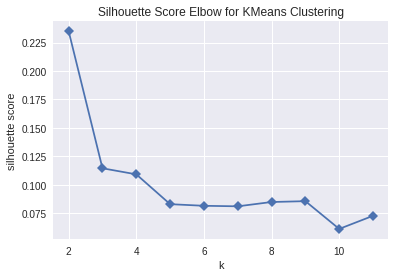

In [200]:
# Instantiate the clustering model and visualizer
yellowbrick.style.rcmod.reset_orig()
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), timings=False, metric='silhouette')

visualizer.fit(StandardScaler().fit_transform(X))    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [201]:
kmeans = KMeans(n_clusters=2, max_iter=1000).fit(scaler.transform(X))

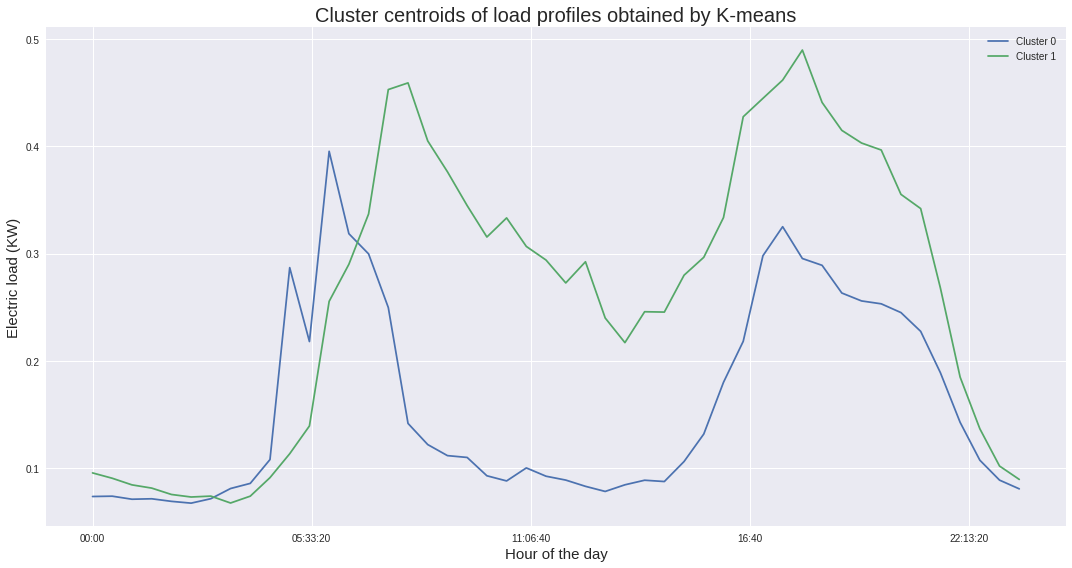

In [202]:
fig, ax = plt.subplots(figsize=(15,8))
for i in range(0,kmeans.n_clusters):
    ax.plot(X.columns, scaler.inverse_transform(kmeans.cluster_centers_[i]), label='Cluster {c}'.format(c=i))

ax.set_title('Cluster centroids of load profiles obtained by K-means', size=20)
ax.set_xlabel('Hour of the day', size=15)
ax.set_ylabel('Electric load (KW)', size=15)
ax.legend()
fig.tight_layout()

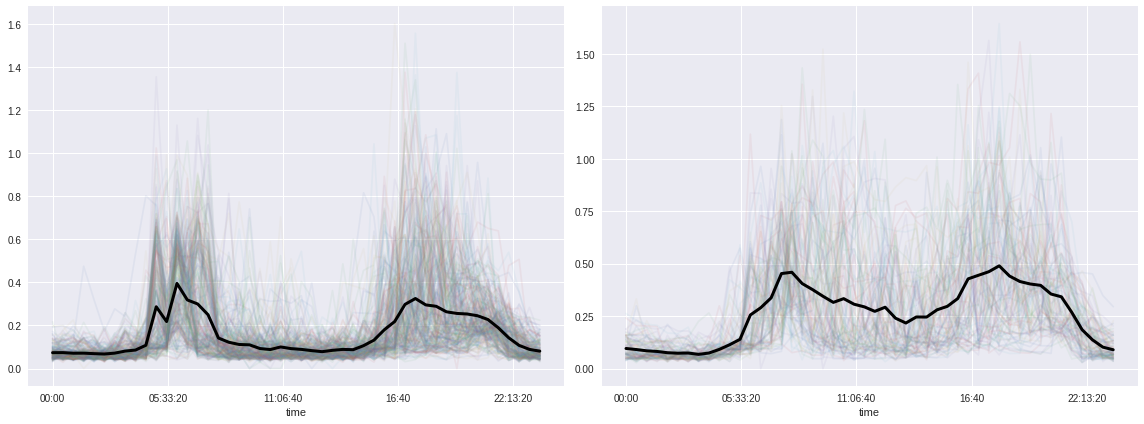

In [203]:
X_cluster= X.copy()
X_cluster['label'] = kmeans.labels_

fig, ax = plt.subplots(figsize=(8*kmeans.n_clusters,6), ncols=kmeans.n_clusters)

for c in range(0,kmeans.n_clusters):
    df_plot = X_cluster[X_cluster.label == c].drop('label', 1).T

    ax[c].plot(df_plot, alpha=0.07)
    ax[c].plot(X.columns, scaler.inverse_transform(kmeans.cluster_centers_[c]), linewidth=3, label='Cluster {c}'.format(c=c), color='black')
    # ax[c].set_ylim(0,7)
fig.tight_layout()

### Agglomertive clustering

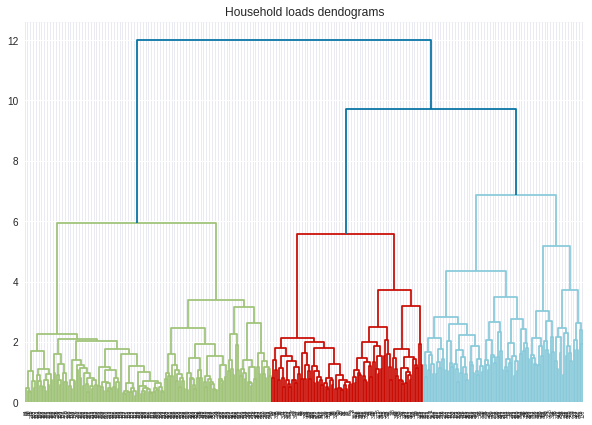

In [204]:
plt.figure(figsize=(10, 7))  
plt.title("Household loads dendograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))  

In [205]:
agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
agg.fit(X)  

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

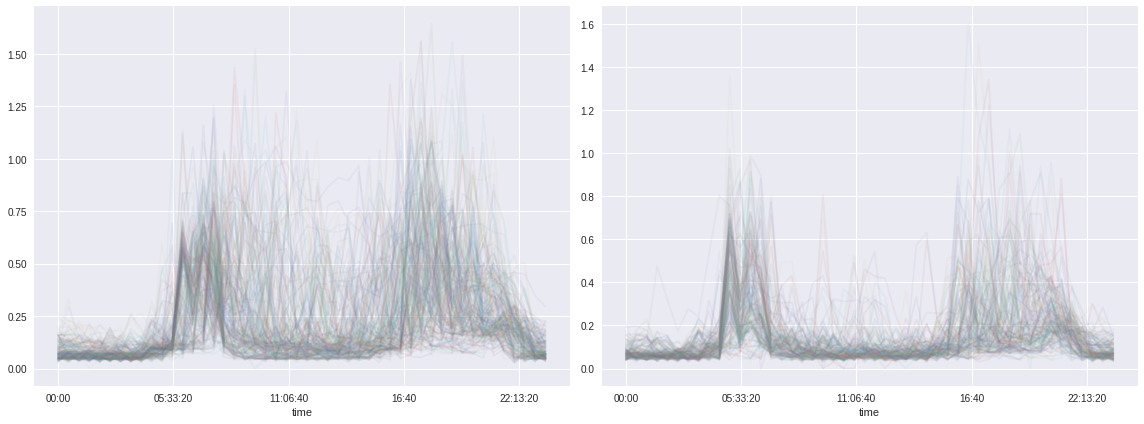

In [206]:
X_cluster= X.copy()
X_cluster['label'] = agg.labels_

fig, ax = plt.subplots(figsize=(8*agg.n_clusters,6), ncols=agg.n_clusters)

for c in range(0,agg.n_clusters):
    df_plot = X_cluster[X_cluster.label == c].drop('label', 1).T

    ax[c].plot(df_plot, alpha=0.07)
   #  ax[c].plot(np.arange(0,24,1), scaler.inverse_transform(kmeans.cluster_centers_[c]), linewidth=3, label='Cluster {c}'.format(c=c), color='black')
    # ax[c].set_ylim(0,7)
fig.tight_layout()

## Clustering based on load indicators

In [207]:
df_sample_hour = df_sample.resample('H').sum()

In [208]:
df_sample_hour = df_sample_hour.reset_index()
df_sample_hour['date'] = df_sample_hour['DateTime'].apply(lambda x: x.date())
df_sample_hour['time'] = df_sample_hour['DateTime'].apply(lambda x: x.time())

In [209]:
df_sample_hour = df_sample_hour.pivot_table(index='date', columns='time', values='consumption')
df_sample_hour.columns = [str(c) for c in df_sample_hour.columns]
df_sample_hour.head()

,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.391,0.285,0.236,0.117,0.109,0.191,0.207,0.177,0.437,0.824,...,0.245,0.255,0.254,0.267,0.590,0.436,0.346,0.334,0.202,0.096
2013-01-02,0.151,0.111,0.184,0.121,0.130,0.331,0.207,0.187,0.527,0.310,...,0.982,0.683,1.157,1.144,0.657,0.701,0.877,0.698,0.242,0.155
2013-01-03,0.132,0.174,0.118,0.146,0.192,0.190,0.751,1.473,0.169,0.098,...,0.103,0.242,0.558,1.942,0.719,0.373,0.445,0.367,0.418,0.179
2013-01-04,0.123,0.104,0.135,0.098,0.184,0.208,0.830,1.140,0.162,0.096,...,0.272,0.232,0.769,1.539,0.758,0.542,0.408,0.687,0.413,0.112
2013-01-05,0.110,0.097,0.140,0.099,0.109,0.213,0.432,0.842,0.603,0.486,...,0.355,0.687,0.383,1.092,1.870,2.201,1.777,0.794,0.543,0.341


In [252]:
X=df_sample_hour.drop(df_sample_hour.columns, 1)

In [253]:
morning = ['06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00']
midday = ['11:00:00','12:00:00', '13:00:00', '14:00:00']
afternoon = ['15:00:00', '16:00:00', '17:00:00', '18:00:00']
evening = ['19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00']
night = ['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00']

base = ['02:00:00', '03:00:00', '04:00:00', '05:00:00']

In [254]:
# total consumption
X['total_consumption'] = df_sample_hour.apply(sum,1)

# Mean daytime loads
X['mean_load_morning'] =  df_sample_hour[morning].apply(np.median,1)
X['mean_load_midday'] =  df_sample_hour[midday].apply(np.median,1)
X['mean_load_afternoon'] =  df_sample_hour[afternoon].apply(np.median,1)
X['mean_load_evening'] =  df_sample_hour[evening].apply(np.median,1)
X['mean_load_night'] =  df_sample_hour[night].apply(np.median,1)

# Base load
X['base_load'] =  df_sample_hour[base].apply(np.median,1)

# Morning maximum
X['morning_maximum'] =  df_sample_hour[morning].apply(np.max,1)

In [255]:
X.head()

,total_consumption,mean_load_morning,mean_load_midday,mean_load_afternoon,mean_load_evening,mean_load_night,base_load,morning_maximum
date,,,,,,,,
2013-01-01,7.358,0.421,0.2230,0.2610,0.334,0.2135,0.1540,0.824
2013-01-02,10.231,0.207,0.2415,0.9135,0.698,0.1405,0.1570,0.527
2013-01-03,9.251,0.169,0.1120,0.6385,0.373,0.1600,0.1680,1.473
2013-01-04,9.242,0.162,0.1205,0.7635,0.413,0.1290,0.1595,1.140
2013-01-05,18.056,0.603,1.1490,0.8895,0.794,0.1095,0.1245,1.117


In [214]:
scaler = StandardScaler().fit(X)

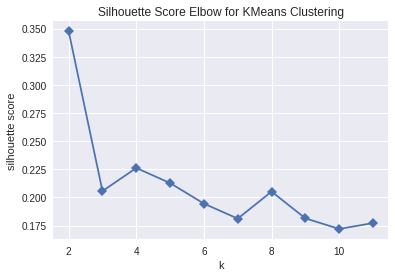

In [215]:
# Instantiate the clustering model and visualizer
yellowbrick.style.rcmod.reset_orig()
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), timings=False, metric='silhouette')

visualizer.fit(StandardScaler().fit_transform(X))    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [233]:
kmeans = KMeans(n_clusters=2, max_iter=1000).fit(scaler.transform(X))

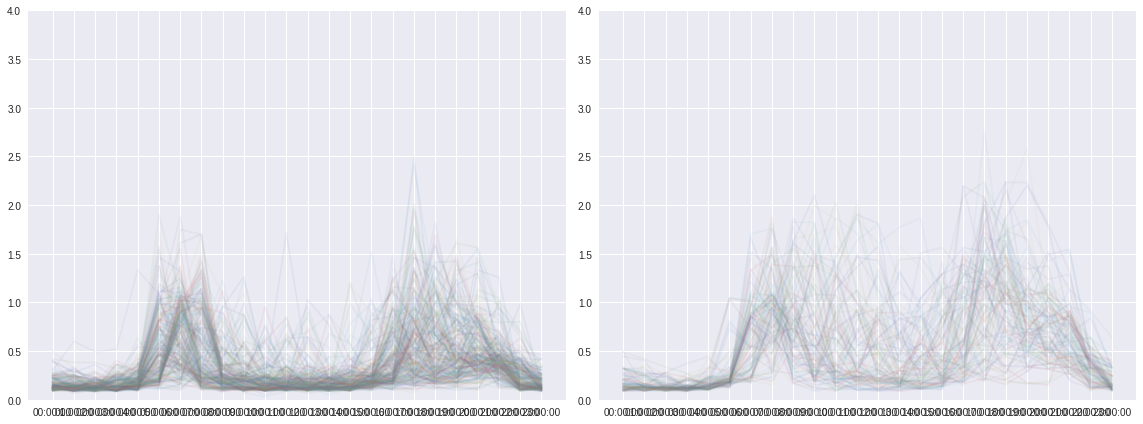

In [234]:
X_cluster= X.copy()
X_cluster['label'] = kmeans.labels_

fig, ax = plt.subplots(figsize=(8*kmeans.n_clusters,6), ncols=kmeans.n_clusters)

for c in range(0,kmeans.n_clusters):
    samples = X_cluster[X_cluster.label == c].index
    df_plot = df_sample_hour.loc[samples]

    ax[c].plot(df_plot.T, alpha=0.07)
    # ax[c].plot(X.columns, scaler.inverse_transform(kmeans.cluster_centers_[c]), linewidth=3, label='Cluster {c}'.format(c=c), color='black')
    ax[c].set_ylim(0,4)
fig.tight_layout()

In [235]:
X_cluster.groupby('label').mean().T

label,0,1
total_consumption,7.547643,12.733441
mean_load_morning,0.263620,0.709431
mean_load_midday,0.175202,0.459789
mean_load_afternoon,0.396122,0.800343
mean_load_evening,0.337213,0.558647
mean_load_night,0.158462,0.149652
base_load,0.179310,0.154985
morning_maximum,0.798951,1.285500


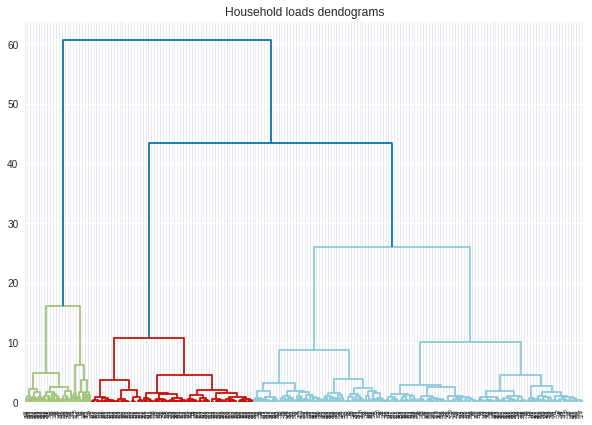

In [236]:
plt.figure(figsize=(10, 7))  
plt.title("Household loads dendograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))  

In [237]:
agg = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
agg.fit(X)  

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func='deprecated')

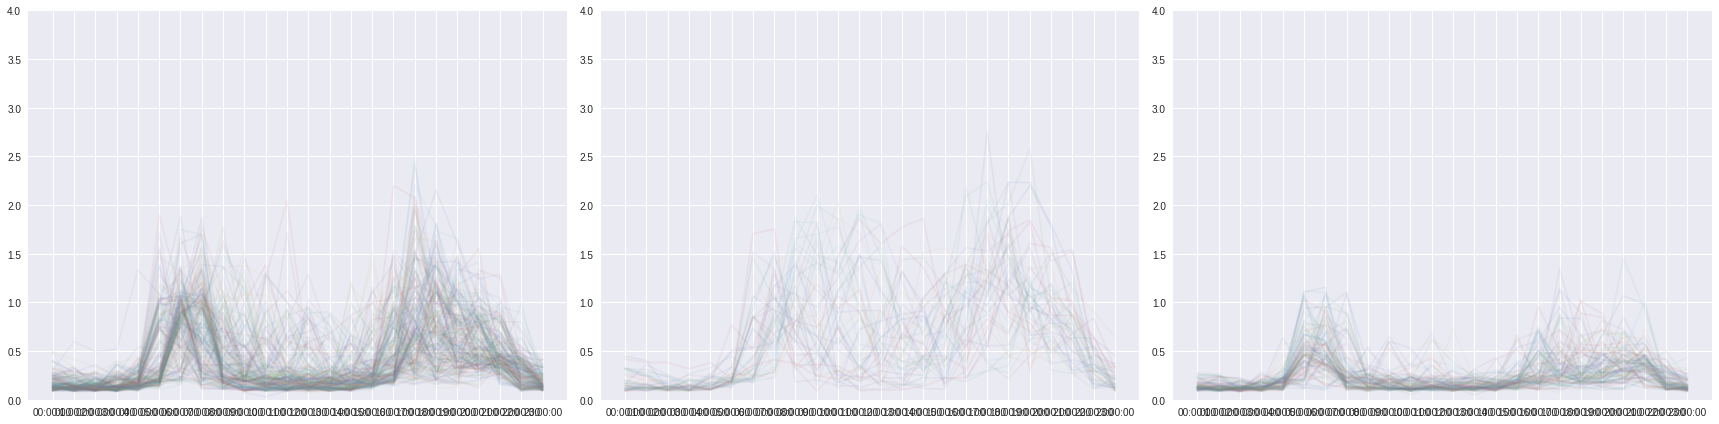

In [238]:
X_cluster= X.copy()
X_cluster['label'] = agg.labels_

fig, ax = plt.subplots(figsize=(8*agg.n_clusters,6), ncols=agg.n_clusters)

for c in range(0,agg.n_clusters):
    samples = X_cluster[X_cluster.label == c].index
    df_plot = df_sample_hour.loc[samples]

    ax[c].plot(df_plot.T, alpha=0.07)
    # ax[c].plot(X.columns, scaler.inverse_transform(kmeans.cluster_centers_[c]), linewidth=3, label='Cluster {c}'.format(c=c), color='black')
    ax[c].set_ylim(0,4)
fig.tight_layout()

In [261]:
cluster_summary(X=X.copy(), y=agg.labels_)

label,0,1,2
total_consumption,9.37,15.08,5.78
mean_load_morning,0.40,0.81,0.19
mean_load_midday,0.22,0.66,0.15
mean_load_afternoon,0.54,0.98,0.26
mean_load_evening,0.41,0.66,0.27
mean_load_night,0.16,0.16,0.15
base_load,0.18,0.16,0.17
morning_maximum,1.04,1.37,0.55
cluster_size,216.00,43.00,106.00
